## Lab 1: 
### Information about data:
Original data set can be found here: https://www.kaggle.com/rtatman/chocolate-bar-ratings

Data contains 9 columns: *Company* (Name of the company manufacturing the bar), *Specific Bean Origin or Bar Name* (The specific geo-region of origin for the bar), *REF* (A value linked to when the review was entered in the database. Higher = more recent), *Review Date* (Date of publication of the review), *Cocoa Percent* (Cocoa percentage (darkness) of the chocolate bar being reviewed), *Company Location* (Manufacturer base country), *Rating* (Expert rating for the bar), *Bean Type* (The variety (breed) of bean used, if provided), *Broad Bean Origin* (The broad geo-region of origin for the bean).

### Steps:
0. Описать задачу словами
1. Прочитать данные
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
3. Обработать пропущенные значения (или убедиться, что их нет)
4. Обработать категориальные признаки
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)
6. Разбить данные на обучающую и тестовую выборки
7. Запустить классификатор ближайших соседей (попробовать разное их количество)
8. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 
9. По желанию: запустить другие классификаторы. Сравнить результаты
10. По желанию: как-то побороться с несбалансированностью классов (если она есть)
11. По желанию: исключить коррелированные переменные (объяснить зачем)
12. Сделать общие выводы

## Step 0: Describe the problem

Need to classify the quality of cocoa. To rate used range from 1 to 5 with 0.25 step

## Step 1: Read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
data = pd.read_csv("./flavors_of_cacao.csv")
data.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


### Additional step: update the data before visualizing

In [3]:
# Rename columns 
original_colnames = data.columns
new_colnames = ['company', 'species', 'REF', 'review_year', 'cocoa_p',
                'company_location', 'rating', 'bean_typ', 'country']
data = data.rename(columns=dict(zip(original_colnames, new_colnames)))

In [4]:
# "REF" and "review_year" approximately means the same, so remove "REF column from the data
data = data.drop("REF", axis=1)

In [5]:
# Modify data types
data['cocoa_p'] = data['cocoa_p'].str.replace('%', '').astype(float)/100

In [6]:
# Update namings of countries
def update_namings(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        if isinstance(text, str):
            text = re.sub(i, j, text)
    return text

data['country'] = data['country'].str.replace('.', '').apply(update_namings)
data['bean_typ'] = data['bean_typ'].str.replace('.', '').apply(update_namings)

## Update misspellings in data['company_location']
data['company_location'] = data['company_location']\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

### Step 2: Visualize the data and collect metrics

In [7]:
data.describe(include="all")

,company,species,review_year,cocoa_p,company_location,rating,bean_typ,country
count,1795,1795,1795.000000,1795.000000,1795,1795.000000,1794,1794
unique,416,1039,NaN,NaN,59,NaN,41,97
top,Soma,Madagascar,NaN,NaN,U.S.A.,NaN,,Venezuela
freq,47,57,NaN,NaN,764,NaN,887,214
mean,NaN,NaN,2012.325348,0.716983,NaN,3.185933,NaN,NaN
std,NaN,NaN,2.927210,0.063231,NaN,0.478062,NaN,NaN
min,NaN,NaN,2006.000000,0.420000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,2010.000000,0.700000,NaN,2.875000,NaN,NaN
50%,NaN,NaN,2013.000000,0.700000,NaN,3.250000,NaN,NaN
75%,NaN,NaN,2015.000000,0.750000,NaN,3.500000,NaN,NaN


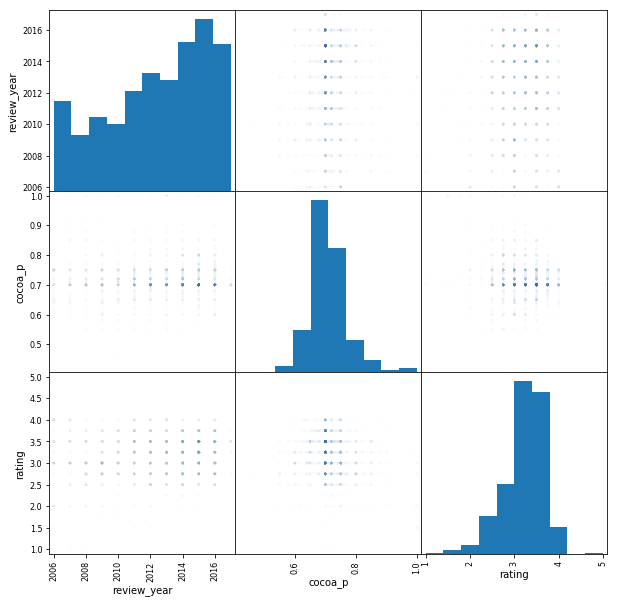

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

According to the table, there is a huge distribution between every pair of real features. 

In [9]:
data.corr()

,review_year,cocoa_p,rating
review_year,1.000000,0.038177,0.099846
cocoa_p,0.038177,1.000000,-0.164820
rating,0.099846,-0.164820,1.000000


Correlation table confirms the absence of dependencies between real features.

#### Create histograms of feature distributions

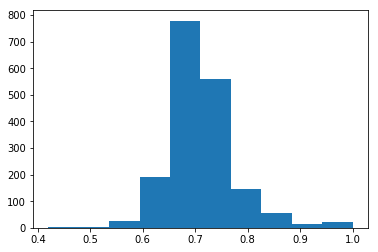

In [10]:
# Visualize distribution of Cocoa Percent
plt.hist(data["cocoa_p"])
pass

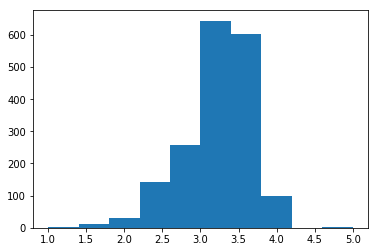

In [11]:
# Visualize distribution of Rating
plt.hist(data["rating"])
pass

### Step 3: Process of missed values

1. Check null values in every column:

In [12]:
for column in data.columns:
    print("Column '{}', number of null values: \n{}\n".format(column, data[column].isnull().value_counts()))

Column 'company', number of null values: 
False    1795
Name: company, dtype: int64

Column 'species', number of null values: 
False    1795
Name: species, dtype: int64

Column 'review_year', number of null values: 
False    1795
Name: review_year, dtype: int64

Column 'cocoa_p', number of null values: 
False    1795
Name: cocoa_p, dtype: int64

Column 'company_location', number of null values: 
False    1795
Name: company_location, dtype: int64

Column 'rating', number of null values: 
False    1795
Name: rating, dtype: int64

Column 'bean_typ', number of null values: 
False    1794
True        1
Name: bean_typ, dtype: int64

Column 'country', number of null values: 
False    1794
True        1
Name: country, dtype: int64



In [13]:
# Because data['country'] contains null values, replace it from data['species']
data['country'] = data['country'].fillna(data['species'])

In [14]:
# Because data['bean_typ'] contains null values, remove corresponding rows
data = data.dropna(subset=["bean_typ"], axis=0)

2. Check empty (' ') values in every column:

In [15]:
for column in data.columns:
    try:
        print("Column '{}', number of empty values: \n{}\n".format(column, len(data[data[column].str.len()==1])))
    except:
        continue

Column 'company', number of empty values: 
0

Column 'species', number of empty values: 
0

Column 'company_location', number of empty values: 
0

Column 'bean_typ', number of empty values: 
887

Column 'country', number of empty values: 
73



In [16]:
# For data["country"] empty value means Blend type of beans
data["country"] = data["country"].str.replace(" ", "Blend")

In [17]:
# TODO: continue
for company in data["company"].unique():
    subdata = data[data["company"] == company]
    subdata = subdata[subdata["bean_typ"].str.len()!=1]
    try:
        argmax = subdata["bean_typ"].value_counts().idxmax()
    except:
        argmax = "Blend"
    